In [10]:
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import random
seed = 666
random.seed(seed)

from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets
torch.manual_seed(seed)

from inv_vae.utils.helpers import Namespace, reset_weights, min_max_standardize, preprocess_neural_data
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 25
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)
plt.rc('axes', linewidth = 2.)

load data

In [62]:
n_rois = 68
count_offset = 100
data_dir = Path("/home/yizi/inv-vae/data/abcd/")
abcd_data_dict = np.load(data_dir/"abcd_data_dict.npy", allow_pickle=True).item()
brain_networks = abcd_data_dict["network"] / count_offset
traits = abcd_data_dict["cog"]
avg_trans = np.nanmean(abcd_data_dict["trans"], -1)
avg_rotat = np.nanmean(abcd_data_dict["rotat"], -1)

print(brain_networks.shape)
print(traits.shape)
print(avg_trans.shape)

(5195, 68, 68)
(5195, 30)
(5195,)


In [63]:
abcd_data = loadmat(data_dir/"abcd_5000.mat")
abcd_cog_desc = abcd_data["nih_cogn_colname"].squeeze()

In [64]:
# abcd_cog_desc

In [65]:
motion = np.c_[avg_trans, avg_rotat]

In [66]:
pic_vocab = traits[:,2]
card_sort = traits[:,8]
oral_reading = traits[:,14]

In [67]:
drop_ids = np.isnan(oral_reading)
oral_reading = oral_reading[~drop_ids]
brain_networks = brain_networks[~drop_ids]
motion = motion[~drop_ids]
n_subs = brain_networks.shape[0]

In [68]:
lr = LinearRegression().fit(motion, oral_reading)
yhat = lr.predict(motion)
oral_reading = oral_reading - yhat

In [69]:
config = Namespace(n_nodes=n_rois, latent_dim=68, hidden_dim=1024, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=3, n_neighbors=32, drop_out=0.,
    beta = 1., add_reg = True, y_dim = 1, 
    batch_size=32, n_epochs=250, lr=1e-5, device=DEVICE)

In [70]:
A_mat = np.mean(brain_networks.reshape(-1,n_rois,n_rois), axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.float32(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i)).float() for i in range(config.n_dec_layers)]

In [71]:
ids = list(range(n_subs))
random.shuffle(ids)
train_ids = ids[:int(.9*n_subs)]
val_ids = ids[int(.9*n_subs):]
print(len(train_ids), len(val_ids))

tensor_nets = torch.stack([torch.Tensor(i) for i in list(brain_networks)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_motion = torch.from_numpy(motion).to(torch.float32)
tensor_traits = torch.from_numpy(oral_reading).to(torch.float32) 

train_set = utils.TensorDataset(tensor_nets[train_ids], tensor_motion[train_ids], tensor_traits[train_ids] )
val_set = utils.TensorDataset(tensor_nets[val_ids], tensor_motion[val_ids],  tensor_traits[val_ids])

train_loader = utils.DataLoader(train_set, config.batch_size) 
val_loader = utils.DataLoader(val_set, config.batch_size)

4617 514


vae

In [73]:
oral_reading_vae = VAE(config).to(config.device)
oral_reading_vae.apply(reset_weights)
oral_reading_vae.set_mask(knn_masks)
optimizer = optim.Adam(oral_reading_vae.parameters(), lr=config.lr) 

In [74]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = oral_reading_vae.reg_train(epoch, train_loader, oral_reading_vae, optimizer, config.device, n_epoch_display=5)
    val_loss = oral_reading_vae.reg_test(epoch, val_loader, oral_reading_vae, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: -730.797 nll: -1084.301 kl: 4.621 rmse: 3.258
epoch: 0 test loss: -2316.596 nll: -2705.528 kl: 2.351 rmse: 3.435
epoch: 5 train loss: -2510.469 nll: -2855.354 kl: 2.577 rmse: 3.226
epoch: 5 test loss: -2496.513 nll: -2879.381 kl: 2.531 rmse: 3.405
epoch: 10 train loss: -2525.215 nll: -2863.200 kl: 4.665 rmse: 3.182
epoch: 10 test loss: -2507.567 nll: -2885.907 kl: 4.705 rmse: 3.372
epoch: 15 train loss: -2535.812 nll: -2866.672 kl: 7.484 rmse: 3.134
epoch: 15 test loss: -2513.709 nll: -2889.667 kl: 7.498 rmse: 3.345
epoch: 20 train loss: -2552.615 nll: -2877.067 kl: 11.509 rmse: 3.083
epoch: 20 test loss: -2525.791 nll: -2901.255 kl: 11.427 rmse: 3.322
epoch: 25 train loss: -2574.684 nll: -2893.526 kl: 14.789 rmse: 3.039
epoch: 25 test loss: -2542.132 nll: -2918.216 kl: 14.063 rmse: 3.311
epoch: 30 train loss: -2595.451 nll: -2904.862 kl: 16.670 rmse: 2.981
epoch: 30 test loss: -2553.708 nll: -2929.655 kl: 15.856 rmse: 3.301
epoch: 35 train loss: -2615.713 nll: -29

inv_vae

In [77]:
# config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=2,
#     n_enc_layers=1, n_dec_layers=3, n_neighbors=32, drop_out=0., 
#     beta = .01, gamma = 0., add_reg = True, y_dim = 1,
#     batch_size=32, n_epochs=1000, lr=1e-5, device=DEVICE)

config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=2,
    n_enc_layers=1, n_dec_layers=3, n_neighbors=32, drop_out=0., 
    beta = .0001, gamma = 0., add_reg = True, y_dim = 1,
    batch_size=32, n_epochs=250, lr=1e-5, device=DEVICE)

In [78]:
oral_reading_inv = INV_VAE(config).to(config.device)
oral_reading_inv.apply(reset_weights)
oral_reading_inv.set_mask(knn_masks)
optimizer = optim.Adam(oral_reading_inv.parameters(), lr=config.lr) 

In [79]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = oral_reading_inv.reg_train(epoch, train_loader, oral_reading_inv, optimizer, config.device, n_epoch_display=5)
    val_loss = oral_reading_inv.reg_test(epoch, val_loader, oral_reading_inv, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 348.617 nll: 5577.018 kl: 26.661 inv_loss: 0.213 rmse: 3.258
epoch: 0 test loss 386.673 nll: 5578.793 kl: 32.071 inv_loss: 0.175 rmse: 3.434
epoch: 5 train loss: 338.030 nll: 5577.662 kl: 114.911 inv_loss: 0.160 rmse: 3.205
epoch: 5 test loss 375.936 nll: 5578.902 kl: 128.888 inv_loss: 0.161 rmse: 3.383
epoch: 10 train loss: 325.038 nll: 5578.122 kl: 299.617 inv_loss: 0.198 rmse: 3.141
epoch: 10 test loss 365.308 nll: 5579.321 kl: 306.193 inv_loss: 0.203 rmse: 3.332
epoch: 15 train loss: 314.298 nll: 5578.506 kl: 521.228 inv_loss: 0.223 rmse: 3.088
epoch: 15 test loss 361.139 nll: 5579.351 kl: 512.572 inv_loss: 0.226 rmse: 3.309
epoch: 20 train loss: 305.508 nll: 5578.717 kl: 702.999 inv_loss: 0.231 rmse: 3.044
epoch: 20 test loss 360.427 nll: 5579.468 kl: 682.463 inv_loss: 0.232 rmse: 3.302
epoch: 25 train loss: 296.992 nll: 5578.902 kl: 833.515 inv_loss: 0.231 rmse: 3.002
epoch: 25 test loss 360.731 nll: 5579.630 kl: 806.341 inv_loss: 0.233 rmse: 3.300
epoch: 30 

In [44]:
# np.save("../saved_res/pic_vocab_vae_pcs_abcd.npy", pic_vocab_vae_pcs)
# np.save("../saved_res/pic_vocab_inv_pcs_abcd.npy", pic_vocab_inv_pcs)

plotting

In [75]:
n=39
x = 0.32 
cmap = plt.cm.jet
lower = cmap(np.linspace(0, x, n))
white = np.ones((80-2*n,4))
upper = cmap(np.linspace(1-x, 1, n))
colors = np.vstack((lower, white, upper))
div_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('div_cmap', colors)

/tmp/ipykernel_90521/1573354850.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


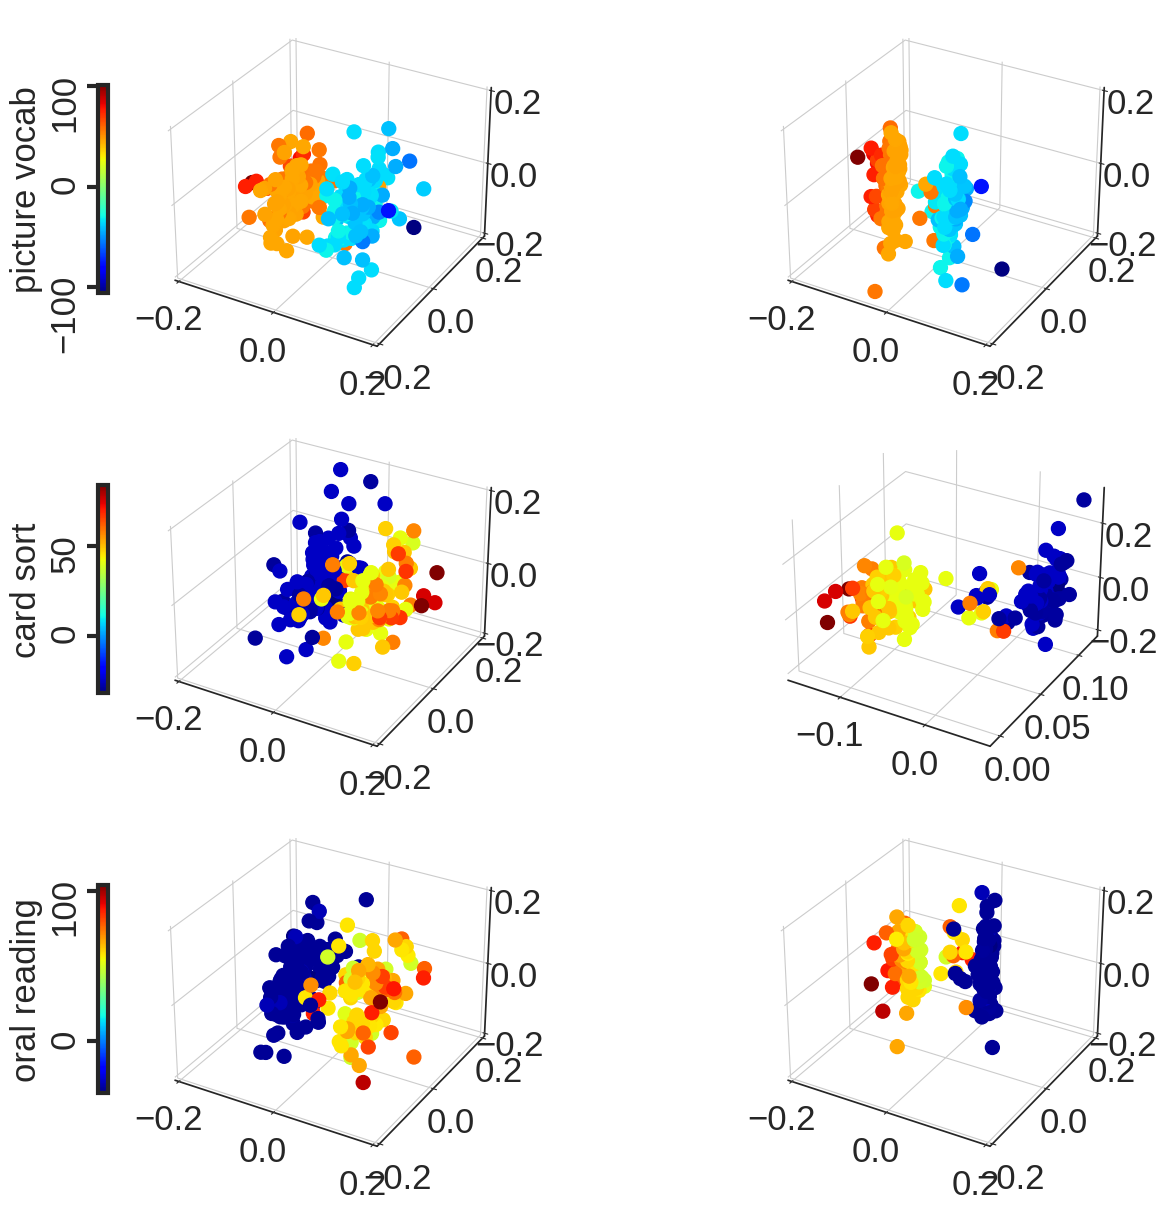

In [81]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12), constrained_layout=True, subplot_kw=dict(projection='3d'))
plt.style.use('seaborn-white')

################## pic vocab - vae ##################
# pic_vocab_vae_z_mean, _ = pic_vocab_vae.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# _, pic_vocab_vae_y_pred, _, _ = pic_vocab_vae(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# pic_vocab_vae_z_mean = pic_vocab_vae_z_mean.detach().cpu().numpy()
# pic_vocab_vae_y_pred = pic_vocab_vae_y_pred.detach().cpu().numpy()

# pic_vocab_y_ids = np.argsort(pic_vocab)
# pic_vocab_y_sub_ids = np.concatenate([pic_vocab_y_ids[:100], pic_vocab_y_ids[-100:]])
# labels = np.concatenate([np.zeros(100), np.ones(100)])
# pic_vocab_vae_colors = pic_vocab[pic_vocab_y_sub_ids]

# pic_vocab_vae_z_mean_sub = pic_vocab_vae_z_mean[pic_vocab_y_sub_ids, :]
# pca = PCA(n_components=3)
# pca.fit(pic_vocab_vae_z_mean_sub.transpose())
# pic_vocab_vae_pcs = pca.components_.transpose()

p1 = axes[0,0].scatter(pic_vocab_vae_pcs[:,0], pic_vocab_vae_pcs[:,1], pic_vocab_vae_pcs[:,2], c=pic_vocab_vae_colors, 
                       cmap = 'jet', s = 100, alpha=1.)
cb = fig.colorbar(p1, ax=axes[0,0], location='left', fraction=0.02, label='picture vocab')
cb.outline.set_linewidth(3)
cb.ax.tick_params(labelrotation=90, length=8, width=3)
axes[0,0].set_xlim3d(-0.2, 0.2)
axes[0,0].set_ylim3d(-0.2, 0.2)
axes[0,0].set_zlim3d(-0.2, 0.2)

################## pic vocab - inv_vae ##################
# pic_vocab_inv_z_mean, _ = pic_vocab_inv.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# _, pic_vocab_inv_y_pred, _, _ = pic_vocab_inv(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
#                                              tensor_motion.to(config.device))
# pic_vocab_inv_z_mean = pic_vocab_inv_z_mean.detach().cpu().numpy()
# pic_vocab_inv_y_pred = pic_vocab_inv_y_pred.detach().cpu().numpy()

# pic_vocab_y_ids = np.argsort(pic_vocab)
# pic_vocab_y_sub_ids = np.concatenate([pic_vocab_y_ids[:100], pic_vocab_y_ids[-100:]])
# labels = np.concatenate([np.zeros(100), np.ones(100)])
# pic_vocab_vae_colors = pic_vocab[pic_vocab_y_sub_ids]

# pic_vocab_inv_z_mean_sub = pic_vocab_inv_z_mean[pic_vocab_y_sub_ids, :]
# pca = PCA(n_components=3)
# pca.fit(pic_vocab_inv_z_mean_sub.transpose())
# pic_vocab_inv_pcs = pca.components_.transpose()

p2 = axes[0,1].scatter(pic_vocab_inv_pcs[:,0], pic_vocab_inv_pcs[:,1], pic_vocab_inv_pcs[:,2], 
                       c=pic_vocab_vae_colors, cmap = 'jet', s = 100, alpha=1.)
axes[0,1].set_xlim3d(-0.2, 0.2)
axes[0,1].set_ylim3d(-0.2, 0.2)
axes[0,1].set_zlim3d(-0.2, 0.2)

################## card sort - vae ##################
# card_sort_vae_z_mean, _ = card_sort_vae.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# _, card_sort_vae_y_pred, _, _ = card_sort_vae(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# card_sort_vae_z_mean = card_sort_vae_z_mean.detach().cpu().numpy()
# card_sort_vae_y_pred = card_sort_vae_y_pred.detach().cpu().numpy()

# card_sort_y_ids = np.argsort(card_sort)
# card_sort_y_sub_ids = np.concatenate([card_sort_y_ids[:100], card_sort_y_ids[-100:]])
# labels = np.concatenate([np.zeros(100), np.ones(100)])
# card_sort_vae_colors = card_sort[card_sort_y_sub_ids]

# card_sort_vae_z_mean_sub = card_sort_vae_z_mean[card_sort_y_sub_ids, :]
# pca = PCA(n_components=3)
# pca.fit(card_sort_vae_z_mean_sub.transpose())
# card_sort_vae_pcs = pca.components_.transpose()

p3 = axes[1,0].scatter(card_sort_vae_pcs[:,0], card_sort_vae_pcs[:,1], card_sort_vae_pcs[:,2], 
                       c=card_sort_vae_colors, cmap = 'jet', s = 100, alpha=1.)
cb = fig.colorbar(p3, ax=axes[1,0], location='left', fraction=0.02, label='card sort')
cb.outline.set_linewidth(3)
cb.ax.tick_params(labelrotation=90, length=8, width=3)
axes[1,0].set_xlim3d(-0.2, 0.2)
axes[1,0].set_ylim3d(-0.2, 0.2)
axes[1,0].set_zlim3d(-0.2, 0.2)

################## card sort - inv_vae ##################
# card_sort_inv_z_mean, _ = card_sort_inv.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# _, card_sort_inv_y_pred, _, _ = card_sort_inv(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
#                                              tensor_motion.to(config.device))
# card_sort_inv_z_mean = card_sort_inv_z_mean.detach().cpu().numpy()
# card_sort_inv_y_pred = card_sort_inv_y_pred.detach().cpu().numpy()

# card_sort_y_ids = np.argsort(card_sort)
# card_sort_y_sub_ids = np.concatenate([card_sort_y_ids[:100], card_sort_y_ids[-100:]])
# labels = np.concatenate([np.zeros(100), np.ones(100)])
# card_sort_vae_colors = card_sort[card_sort_y_sub_ids]

# card_sort_inv_z_mean_sub = card_sort_inv_z_mean[card_sort_y_sub_ids, :]
# pca = PCA(n_components=3)
# pca.fit(card_sort_inv_z_mean_sub.transpose())
# card_sort_inv_pcs = pca.components_.transpose()

p4 = axes[1,1].scatter(card_sort_inv_pcs[:,0], card_sort_inv_pcs[:,1], card_sort_inv_pcs[:,2], c=card_sort_vae_colors, 
                       cmap = 'jet', s = 100, alpha=1.)
# axes[1,1].set_xlim3d(-0.2, 0.2)
# axes[1,1].set_ylim3d(-0.2, 0.2)
# axes[1,1].set_zlim3d(-0.2, 0.2)

################## oral reading - vae ##################
# oral_reading_vae_z_mean, _ = oral_reading_vae.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# _, oral_reading_vae_y_pred, _, _ = oral_reading_vae(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# oral_reading_vae_z_mean = oral_reading_vae_z_mean.detach().cpu().numpy()
# oral_reading_vae_y_pred = oral_reading_vae_y_pred.detach().cpu().numpy()

# oral_reading_y_ids = np.argsort(oral_reading)
# oral_reading_y_sub_ids = np.concatenate([oral_reading_y_ids[:100], oral_reading_y_ids[-100:]])
# labels = np.concatenate([np.zeros(100), np.ones(100)])
# oral_reading_vae_colors = oral_reading[oral_reading_y_sub_ids]

# oral_reading_vae_z_mean_sub = oral_reading_vae_z_mean[oral_reading_y_sub_ids, :]
# pca = PCA(n_components=3)
# pca.fit(oral_reading_vae_z_mean_sub.transpose())
# oral_reading_vae_pcs = pca.components_.transpose()

p5 = axes[2,0].scatter(oral_reading_vae_pcs[:,0], oral_reading_vae_pcs[:,1], oral_reading_vae_pcs[:,2], 
                       c=oral_reading_vae_colors, cmap = 'jet', s = 100, alpha=1.)
cb = plt.colorbar(p5, ax=axes[2,0], location='left', fraction=0.02, label='oral reading')
cb.outline.set_linewidth(3)
cb.ax.tick_params(labelrotation=90, length=8, width=3)
axes[2,0].set_xlim3d(-0.2, 0.2)
axes[2,0].set_ylim3d(-0.2, 0.2)
axes[2,0].set_zlim3d(-0.2, 0.2)


################## oral reading - inv_vae ##################
oral_reading_inv_z_mean, _ = oral_reading_inv.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
_, oral_reading_inv_y_pred, _, _ = oral_reading_inv(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
                                             tensor_motion.to(config.device))
oral_reading_inv_z_mean = oral_reading_inv_z_mean.detach().cpu().numpy()
oral_reading_inv_y_pred = oral_reading_inv_y_pred.detach().cpu().numpy()

oral_reading_y_ids = np.argsort(oral_reading)
oral_reading_y_sub_ids = np.concatenate([oral_reading_y_ids[:100], oral_reading_y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
oral_reading_vae_colors = oral_reading[oral_reading_y_sub_ids]

oral_reading_inv_z_mean_sub = oral_reading_inv_z_mean[oral_reading_y_sub_ids, :]
pca = PCA(n_components=3)
pca.fit(oral_reading_inv_z_mean_sub.transpose())
oral_reading_inv_pcs = pca.components_.transpose()

p6 = axes[2,1].scatter(oral_reading_inv_pcs[:,0], oral_reading_inv_pcs[:,1], oral_reading_inv_pcs[:,2], 
                       c=oral_reading_vae_colors, cmap = 'jet', s = 100, alpha=1.)
axes[2,1].set_xlim3d(-0.2, 0.2)
axes[2,1].set_ylim3d(-0.2, 0.2)
axes[2,1].set_zlim3d(-0.2, 0.2)

for i in range(3):
    for j in range(2):
        axes[i,j].xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        axes[i,j].yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        axes[i,j].zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        

plt.savefig('../saved_figs/fig8_abcd_trait_latents.png', facecolor='white', dpi=800)
plt.show()